# This notebook is laid out as follows:
## 1) A cell of imports. First, run it and make sure all dependancies are installed.
## 2) The default methods needed to run the example code.
## 3) A series of experiments, with the following layout:
          a) Definition of a preprocessing method, where relevant
          b) A cell vizualizing the preprocessing stage.
          c) A cell initializing a monitor-wrapped environment.
          d) A cell running TPG in the environment with teams of 100 for 100 generations.
          e) A simple plot showing the average score over generation.
## 4) A plot charting the performance of each experiment.

### The experiments are conducted in the following order:
        1) Default settings. Uses the red channel of the environment as the state. This is a replica of Ryan
           Amaral's example, modified to use a monitor wrapper instead of rendering the game in the notebook.
        2) Preprocessing variant 1. The state is preprocessed to be a condensed, grayscale version of the 
           original state.
        3) Preprocessing variant 2. The state is preprocessed by cropping 'irrelevant' features of the game 
           screen and then converting all colored pixels to simply have the value '1'.
        4) Frame Differential as state. The state is preprocessed using variant 2. Then, the previous state is 
           subtracted from it. The difference between states is passed to the agent.
        5) Convolutional preprocessing. The state is convolved with an edge detector kernel prior to being 
           passed to the agent.
### Running the notebook will create a folder for each experiment containing metadata and video. It will also create a file that stores the run time and score results of each experiment.

In [1]:
#Run this block to make sure you have the dependancies installed
#Anything that doesn't work can usually be resolved using pip
import tpg
import numpy as np
import matplotlib.pyplot as plt
import gym
import gym.spaces
from gym import wrappers
from tpg.tpg_trainer import TpgTrainer
from tpg.tpg_agent import TpgAgent
import time
from IPython import display
from scipy import misc
import scipy.signal as sp
from skimage import color
from skimage import transform
import pickle

results = [] #A list to store the run times and scores of each run 

In [2]:
#functions for rendering over Jupyter as used in Ryan Ameral's example
def show_state(env, step=0, name='', info=''):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Step: %d %s" % (name, step, info))
    plt.axis('off')
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
#uses only red instead of RGB
def getState(state):
    state2 = []
    for x in state:
        for y in x:
            state2.append(y[0])
            
    return state2
#NOTE: I never use this function outside of the default example. I use preprocess() instead

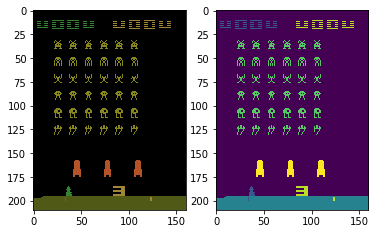

In [3]:
#Show what the showState function does.
env = gym.make('SpaceInvaders-v0')
testState = env.reset()
testState,a,b,c = env.step(1)

redLayer = getState(testState)
redLayer = np.reshape(redLayer, (210, 160,))

plt.figure(1)
plt.subplot(121)
plt.imshow(testState)
plt.subplot(122)
plt.imshow(redLayer)
plt.show()

In [4]:
#build openAI gym environment and print the size of the action space
env = gym.make('SpaceInvaders-v0')
#wrap the env object so that we can save video of the learning process :)
#note that this will end up saving to the directory which the code is saved in
env = wrappers.Monitor(env, './videos/space-invaders-experiment1-default-settings', force=True)
print(env.action_space)

Discrete(6)


In [5]:
#First run: A simple replica of Ryan Amaral's example, modified to use the monitor wrapper.
#Also modified to not render, resulting in significantly improved run time.

#used to track time
tStart = time.time()

# first create an instance of the TpgTrainer
# this creates the whole population and everything
trainer = TpgTrainer(actions=range(6), teamPopSize=50)

curScores = [] # hold scores in a generation
summaryScores = [] # record score summaries for each gen (min, max, avg)

isDone = True
#Try running for 20 gens and see how long it takes.
for gen in range(100): # generation loop
    curScores = [] # new list per gen
    print("Generation ",gen)
    while True: # loop to go through agents
        teamNum = trainer.remainingAgents()
        agent = trainer.getNextAgent()
        if agent is None:
            break # no more agents, so proceed to next gen
        
        # check if agent already has score
        if agent.taskDone():
            score = agent.getOutcome()
        else:
            if isDone:
                state = env.reset() # get initial state and prep environment
            score = 0
            for i in range(201): # run episodes that last 200 frames

                act = agent.act(getState(state)) # get action from agent

                # feedback from env
                state, reward, isDone, debug = env.step(act)
                score += reward # accumulate reward in score
                if isDone:
                    break # end early if losing state

            agent.reward(score) # must reward agent (if didn't already score)
            
        curScores.append(score) # store score
            
    # at end of generation, make summary of scores
    summaryScores.append((min(curScores), max(curScores),
                    sum(curScores)/len(curScores))) # min, max, avg
    trainer.evolve()
    
finalTime = time.time() - tStart
print('Time Taken (Seconds): ', finalTime)
print('Results:\nMin, Max, Avg')
for result in summaryScores:
    print(result[0],result[1],result[2])
results.append({'Default':{'time': finalTime , 'scores':summaryScores}})

Generation  0
Generation  1
Generation  2
Generation  3
Generation  4
Generation  5
Generation  6
Generation  7
Generation  8
Generation  9
Generation  10
Generation  11
Generation  12
Generation  13
Generation  14
Generation  15
Generation  16
Generation  17
Generation  18
Generation  19
Generation  20
Generation  21
Generation  22
Generation  23
Generation  24
Generation  25
Generation  26
Generation  27
Generation  28
Generation  29
Generation  30
Generation  31
Generation  32
Generation  33
Generation  34
Generation  35
Generation  36
Generation  37
Generation  38
Generation  39
Generation  40
Generation  41
Generation  42
Generation  43
Generation  44
Generation  45
Generation  46
Generation  47
Generation  48
Generation  49
Generation  50
Generation  51
Generation  52
Generation  53
Generation  54
Generation  55
Generation  56
Generation  57
Generation  58
Generation  59
Generation  60
Generation  61
Generation  62
Generation  63
Generation  64
Generation  65
Generation  66
Gener

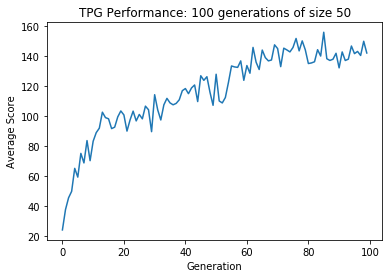

In [7]:
#Plot the average score per generation. 
#At the end, We will plot all variants.
avgs = [x[2] for x in summaryScores]
plt.plot(avgs)
plt.xlabel('Generation')
plt.ylabel('Average Score')
plt.title('TPG Performance: 100 generations of size 50')
plt.show()

In [8]:
#A function to preprocess the image.
#The hypothesis is that passing smaller, greyscale image will allow the agent to learn faster
#This is a common simple feature extraction procedure for computer vision
def preprocess(observation):
    #use numpy to convert each pixel to grayscale
    
    grayscale_observation = observation.mean(2)

    # Resize grayscale frame to a 47x47 matrix of 32-bit floats.
    resized_observation = transform.resize(grayscale_observation, (47, 47)).astype(np.float32)

    return np.expand_dims(resized_observation, 2)



/home/alex/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/alex/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


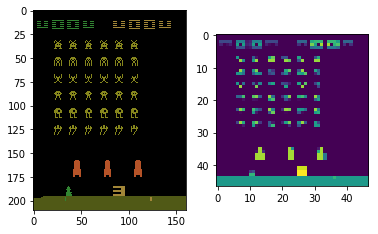

In [9]:
processed = preprocess(testState)
processed = np.reshape(processed, (47, 47,))

plt.figure(1)
plt.subplot(121)
plt.imshow(testState)
plt.subplot(122)
plt.imshow(processed)
plt.show()

In [10]:
#Because we used a monitor, we need to initialize a new environment
env = gym.make('SpaceInvaders-v0')
env = wrappers.Monitor(env, './videos/space-invaders-experiment2-simple-preprocess', force=True)
print(env.action_space)

Discrete(6)


In [11]:
#The same code, this time modified to preprocess the image each time a state object is returned
%matplotlib inline

tStart = time.time()

trainer = TpgTrainer(actions=range(6), teamPopSize=50)

curScores = [] 
pp_summaryScores = []

isDone = True
for gen in range(100):
    curScores = [] 
    print("Training generation ",gen,". . .")
    while True: 
        teamNum = trainer.remainingAgents()
        agent = trainer.getNextAgent()
        if agent is None:
            break 
        
        if agent.taskDone():
            score = agent.getOutcome()
        else:
            if isDone:
                state = preprocess(env.reset()) # preprocess the initial state
            score = 0
            for i in range(201):
                act = agent.act(state) # get action from agent
                # feedback from env
                state, reward, isDone, debug = env.step(act)
                state = preprocess(state) #process the state returned at each step
                score += reward # accumulate reward in score
                if isDone:
                    break # end early if losing state

            agent.reward(score)
            
        curScores.append(score)
            
    pp_summaryScores.append((min(curScores), max(curScores),
                    sum(curScores)/len(curScores)))
    trainer.evolve()
    
finalTime = time.time() - tStart
print('Time Taken (Seconds): ', finalTime)
print('Results:\nMin, Max, Avg')
for result in pp_summaryScores:
    print(result[0],result[1],result[2])
results.append({'preprocess_var1':{'time': finalTime , 'scores':pp_summaryScores}})

Training generation  0 . . .


/home/alex/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/alex/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/alex/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/alex/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will

Training generation  1 . . .
Training generation  2 . . .
Training generation  3 . . .
Training generation  4 . . .


/home/alex/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/alex/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Training generation  5 . . .
Training generation  6 . . .
Training generation  7 . . .
Training generation  8 . . .
Training generation  9 . . .
Training generation  10 . . .
Training generation  11 . . .
Training generation  12 . . .
Training generation  13 . . .


/home/alex/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/alex/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Training generation  14 . . .
Training generation  15 . . .
Training generation  16 . . .
Training generation  17 . . .
Training generation  18 . . .
Training generation  19 . . .
Training generation  20 . . .
Training generation  21 . . .
Training generation  22 . . .
Training generation  23 . . .
Training generation  24 . . .
Training generation  25 . . .
Training generation  26 . . .
Training generation  27 . . .
Training generation  28 . . .
Training generation  29 . . .
Training generation  30 . . .
Training generation  31 . . .


/home/alex/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/alex/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Training generation  32 . . .
Training generation  33 . . .
Training generation  34 . . .
Training generation  35 . . .
Training generation  36 . . .
Training generation  37 . . .
Training generation  38 . . .
Training generation  39 . . .
Training generation  40 . . .
Training generation  41 . . .
Training generation  42 . . .
Training generation  43 . . .
Training generation  44 . . .
Training generation  45 . . .
Training generation  46 . . .
Training generation  47 . . .
Training generation  48 . . .
Training generation  49 . . .
Training generation  50 . . .
Training generation  51 . . .
Training generation  52 . . .
Training generation  53 . . .
Training generation  54 . . .
Training generation  55 . . .
Training generation  56 . . .
Training generation  57 . . .
Training generation  58 . . .
Training generation  59 . . .


/home/alex/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/alex/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Training generation  60 . . .
Training generation  61 . . .
Training generation  62 . . .
Training generation  63 . . .
Training generation  64 . . .
Training generation  65 . . .
Training generation  66 . . .
Training generation  67 . . .
Training generation  68 . . .
Training generation  69 . . .
Training generation  70 . . .
Training generation  71 . . .
Training generation  72 . . .
Training generation  73 . . .
Training generation  74 . . .
Training generation  75 . . .
Training generation  76 . . .
Training generation  77 . . .
Training generation  78 . . .
Training generation  79 . . .
Training generation  80 . . .
Training generation  81 . . .
Training generation  82 . . .
Training generation  83 . . .
Training generation  84 . . .
Training generation  85 . . .
Training generation  86 . . .
Training generation  87 . . .
Training generation  88 . . .
Training generation  89 . . .
Training generation  90 . . .
Training generation  91 . . .
Training generation  92 . . .
Training g

/home/alex/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/alex/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Training generation  95 . . .
Training generation  96 . . .
Training generation  97 . . .
Training generation  98 . . .
Training generation  99 . . .
Time Taken (Seconds):  816.2366607189178
Results:
Min, Max, Avg
0.0 260.0 37.9
0.0 260.0 53.191489361702125
0.0 260.0 55.111111111111114
0.0 260.0 64.33333333333333
0.0 255.0 51.16279069767442
0.0 260.0 74.11111111111111
0.0 260.0 76.86046511627907
0.0 260.0 81.88888888888889
0.0 260.0 81.73913043478261
0.0 260.0 84.18604651162791
0.0 260.0 79.04761904761905
0.0 260.0 89.76744186046511
0.0 260.0 80.26315789473684
0.0 260.0 88.25
0.0 260.0 95.51282051282051
0.0 260.0 90.25
0.0 290.0 101.92307692307692
0.0 290.0 102.77777777777777
0.0 290.0 104.44444444444444
0.0 260.0 92.02702702702703
0.0 290.0 97.56410256410257
0.0 290.0 119.21052631578948
0.0 290.0 115.13513513513513
0.0 290.0 110.26315789473684
0.0 290.0 106.71428571428571
0.0 290.0 119.25
0.0 290.0 121.84210526315789
0.0 290.0 108.28947368421052
0.0 290.0 118.125
0.0 290.0 132.2368421

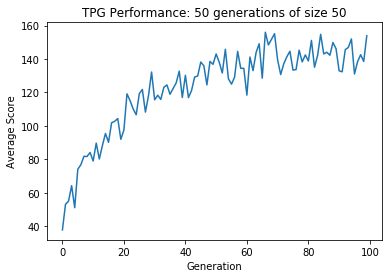

In [12]:
pp_avgs = [x[2] for x in pp_summaryScores]
plt.plot(pp_avgs)
plt.xlabel('Generation')
plt.ylabel('Average Score')
plt.title('TPG Performance: 50 generations of size 50')
plt.show()

In [13]:
#This code will use a different preprocessing approach.
#The idea is to crop the image (removing the score from the top) and downsize.
#then, set all colored pixels to simply have the value "1"
#I would usually set the data type to float but due to the bitarray processing that happens later this may be best omitted

def preprocess_variant2(observation):
    #image processing
    pro_obs = observation[35:195] # crop the top bit out
    pro_obs = pro_obs[::2,::2,0] #downsamples by factor of two, a successful approach seen for Pong
    pro_obs[pro_obs != 0] = 1 #change all other pixel values to just be 1.
    # Convert from 80 x 80 matrix to 1600 x 1 matrix
    pro_obs = pro_obs.ravel()
    return pro_obs


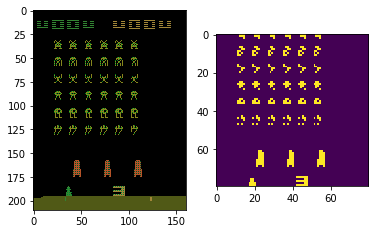

In [14]:
processed = preprocess_variant2(testState)
processed = np.reshape(processed, (80, 80,))

plt.figure(1)
plt.subplot(121)
plt.imshow(testState)
plt.subplot(122)
plt.imshow(processed)
plt.show()

In [15]:
#Make a new environment and monitor.
env = gym.make('SpaceInvaders-v0')
env = wrappers.Monitor(env, './videos/space-invaders-experiment-3-preprocessing-variant-2', force=True)
print(env.action_space)

Discrete(6)


In [17]:
#Run again using the alternative method of preprocessing.
%matplotlib inline

tStart = time.time()

trainer = TpgTrainer(actions=range(6), teamPopSize=50)

curScores = [] 
pp2_summaryScores = [] 

isDone = True
for gen in range(100): 
    curScores = [] 
    print("Training generation ",gen,". . .")
    while True:
        teamNum = trainer.remainingAgents()
        agent = trainer.getNextAgent()
        if agent is None:
            break
        
        if agent.taskDone():
            score = agent.getOutcome()
        else:
            if isDone:
                state = preprocess_variant2(env.reset()) # process initial state
            score = 0
            for i in range(201):
                act = agent.act(state) # get action from agent
                # feedback from env
                state, reward, isDone, debug = env.step(act)
                state = preprocess_variant2(state) #Process state returned by step()
                score += reward # accumulate reward in score
                if isDone:
                    break # end early if losing state
            agent.reward(score)
            
        curScores.append(score)
            
    pp2_summaryScores.append((min(curScores), max(curScores),
                    sum(curScores)/len(curScores)))
    trainer.evolve()
    
finalTime = time.time() - tStart
print('Time Taken (Seconds): ', finalTime)
print('Results:\nMin, Max, Avg')
for result in pp_summaryScores:
    print(result[0],result[1],result[2])
results.append({'preprocess_variant2':{'time': finalTime , 'scores':pp2_summaryScores}})

Training generation  0 . . .
Training generation  1 . . .
Training generation  2 . . .
Training generation  3 . . .
Training generation  4 . . .
Training generation  5 . . .
Training generation  6 . . .
Training generation  7 . . .
Training generation  8 . . .
Training generation  9 . . .
Training generation  10 . . .
Training generation  11 . . .
Training generation  12 . . .
Training generation  13 . . .
Training generation  14 . . .
Training generation  15 . . .
Training generation  16 . . .
Training generation  17 . . .
Training generation  18 . . .
Training generation  19 . . .
Training generation  20 . . .
Training generation  21 . . .
Training generation  22 . . .
Training generation  23 . . .
Training generation  24 . . .
Training generation  25 . . .
Training generation  26 . . .
Training generation  27 . . .
Training generation  28 . . .
Training generation  29 . . .
Training generation  30 . . .
Training generation  31 . . .
Training generation  32 . . .
Training generation 

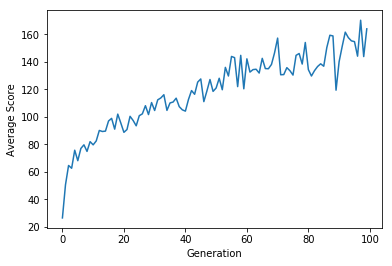

In [18]:
pp2_avgs = [x[2] for x in pp2_summaryScores]
plt.plot(pp2_avgs)
plt.xlabel('Generation')
plt.ylabel('Average Score')
plt.show()

In [19]:
#Make a new environment and monitor.
env = gym.make('SpaceInvaders-v0')
env = wrappers.Monitor(env, './videos/space-invaders-experiment-4-state-as-difference-in-frames', force=True)
print(env.action_space)

Discrete(6)


In [20]:
#Run again. This time, use the difference between processed frames as the state
%matplotlib inline

tStart = time.time()

trainer = TpgTrainer(actions=range(6), teamPopSize=50)

curScores = [] 
df_summaryScores = []

isDone = True
prev_obs = None #used later
for gen in range(100):
    curScores = [] 
    print("Training generation ",gen,". . .")
    while True:
        teamNum = trainer.remainingAgents()
        agent = trainer.getNextAgent()
        if agent is None:
            break
        
        if agent.taskDone():
            score = agent.getOutcome()
        else:
            if isDone:
                obs = preprocess_variant2(env.reset()) # get initial state and prep environment
                 #Calculate the difference between the prior observation and the current state. pass the difference as state
                state = obs - prev_obs if prev_obs is not None else np.zeros(1600)
                prev_obs = obs
            score = 0
            for i in range(201):
                act = agent.act(state) # get action from agent
                # feedback from env
                obs, reward, isDone, debug = env.step(act)
                obs = preprocess_variant2(obs) #Again process the state
                state = obs - prev_obs if prev_obs is not None else np.zeros(1600)
                prev_obs = obs
                score += reward # accumulate reward in score
                if isDone:
                    break # end early if losing state

            agent.reward(score)
            
        curScores.append(score)
            
    df_summaryScores.append((min(curScores), max(curScores),
                    sum(curScores)/len(curScores)))
    trainer.evolve()
    
finalTime = time.time() - tStart
print('Time Taken (Seconds): ', finalTime)
print('Results:\nMin, Max, Avg')
for result in pp_summaryScores:
    print(result[0],result[1],result[2])
results.append({'differential_state':{'time': finalTime , 'scores':df_summaryScores}})

Training generation  0 . . .
Training generation  1 . . .
Training generation  2 . . .
Training generation  3 . . .
Training generation  4 . . .
Training generation  5 . . .
Training generation  6 . . .
Training generation  7 . . .
Training generation  8 . . .
Training generation  9 . . .
Training generation  10 . . .
Training generation  11 . . .
Training generation  12 . . .
Training generation  13 . . .
Training generation  14 . . .
Training generation  15 . . .
Training generation  16 . . .
Training generation  17 . . .
Training generation  18 . . .
Training generation  19 . . .
Training generation  20 . . .
Training generation  21 . . .
Training generation  22 . . .
Training generation  23 . . .
Training generation  24 . . .
Training generation  25 . . .
Training generation  26 . . .
Training generation  27 . . .
Training generation  28 . . .
Training generation  29 . . .
Training generation  30 . . .
Training generation  31 . . .
Training generation  32 . . .
Training generation 

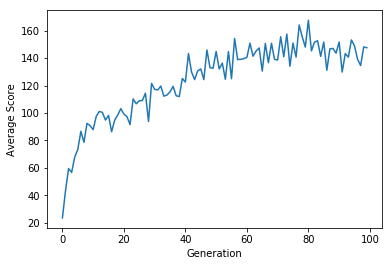

In [21]:
#Plot the average scores per generation
df_avgs = [x[2] for x in df_summaryScores]
#plt.plot(avgs)
plt.plot(df_avgs)
plt.xlabel('Generation')
plt.ylabel('Average Score')
plt.show()

In [22]:
#Try using a convolution as the preprocessing step
edge_kernel = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]]) #an edge detection kernel
def convolution(obs):
    edge = color.rgb2gray(obs)
    edge = sp.convolve2d(edge, edge_kernel, 'valid')
    edge = edge.ravel()
    return edge
    

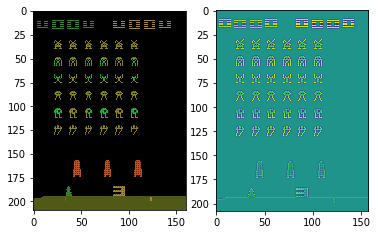

In [23]:
processed = convolution(testState)
processed = np.reshape(processed, (208, 158,))

plt.figure(1)
plt.subplot(121)
plt.imshow(testState)
plt.subplot(122)
plt.imshow(processed)
plt.show()

In [24]:
#Make a new environment and monitor.
env = gym.make('SpaceInvaders-v0')
env = wrappers.Monitor(env, './videos/space-invaders-experiment-5-edge-detection', force=True)
print(env.action_space)

Discrete(6)


In [25]:
#Try again, this time using convoluted image as state input.
%matplotlib inline

tStart = time.time()

trainer = TpgTrainer(actions=range(6), teamPopSize=50)

curScores = [] # hold scores in a generation
conv_summaryScores = []

isDone = True
prev_obs = None 
for gen in range(100):
    curScores = [] 
    print("Training generation ",gen,". . .")
    while True: 
        teamNum = trainer.remainingAgents()
        agent = trainer.getNextAgent()
        if agent is None:
            break
        
        if agent.taskDone():
            score = agent.getOutcome()
        else:
            if isDone:
                obs = convolution(env.reset())
            score = 0
            for i in range(201): 
                act = agent.act(state)
                # feedback from env
                obs, reward, isDone, debug = env.step(act)
                obs = convolution(obs) #Convolute the state 
                score += reward 
                if isDone:
                    break 

            agent.reward(score)
            
        curScores.append(score)
            
    conv_summaryScores.append((min(curScores), max(curScores),
                    sum(curScores)/len(curScores))) # min, max, avg
    trainer.evolve()
    
finalTime = time.time() - tStart
print('Time Taken (Seconds): ', finalTime)
print('Results:\nMin, Max, Avg')
for result in conv_summaryScores:
    print(result[0],result[1],result[2])
results.append({'differential_state':{'time': finalTime , 'scores':df_summaryScores}})

Training generation  0 . . .
Training generation  1 . . .
Training generation  2 . . .
Training generation  3 . . .
Training generation  4 . . .
Training generation  5 . . .
Training generation  6 . . .
Training generation  7 . . .
Training generation  8 . . .
Training generation  9 . . .
Training generation  10 . . .
Training generation  11 . . .
Training generation  12 . . .
Training generation  13 . . .
Training generation  14 . . .
Training generation  15 . . .
Training generation  16 . . .
Training generation  17 . . .
Training generation  18 . . .
Training generation  19 . . .
Training generation  20 . . .
Training generation  21 . . .
Training generation  22 . . .
Training generation  23 . . .
Training generation  24 . . .
Training generation  25 . . .
Training generation  26 . . .
Training generation  27 . . .
Training generation  28 . . .
Training generation  29 . . .
Training generation  30 . . .
Training generation  31 . . .
Training generation  32 . . .
Training generation 

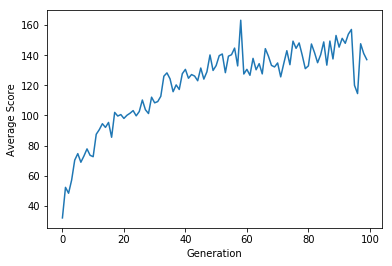

In [26]:
conv_avgs = [x[2] for x in conv_summaryScores]
plt.plot(conv_avgs)
plt.xlabel('Generation')
plt.ylabel('Average Score')
plt.show()

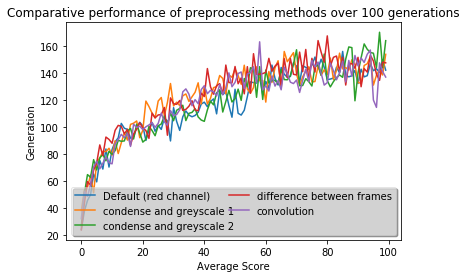

In [27]:
#plot them all!
plt.plot(avgs, label = 'Default (red channel)')
plt.plot(pp_avgs, label='condense and greyscale 1' )
plt.plot(pp2_avgs, label='condense and greyscale 2')
plt.plot(df_avgs, label='difference between frames')
plt.plot(conv_avgs, label='convolution')
plt.xlabel('Average Score')
plt.ylabel('Generation')
plt.title('Comparative performance of preprocessing methods over 100 generations')
leg = plt.legend(loc='best', ncol=2, mode="expand", shadow=True, fancybox=True)
leg.get_frame().set_alpha(0.5)
plt.show()

In [28]:
#Pickle the results to a file to save them.
#To retrieve use pickle.load
with open('results.txt', 'wb') as fp:
    pickle.dump(results, fp)